# Sarcasm Detection using News Headlines

## Overview

I bear specific interest in working on intelligence related to how humans communicate i.e human language in various ways (mainly speech and text). 

> _Sarcasm is a sharp and often satirical or ironic utterance designed to cut or give pain__

Detection of sarcasm is important in areas such as affective computing and sentiment analysis because such expressions can flip the polarity of a sentence. Examples include statements such as “Is it time for your medication or mine?” and “I work 40 hours a week to be this poor”.

This problem falls in the domain of __Natural Language Processing__, also known as __NLP__

In this project, I will try to develop a model for detecting sarcasm in sentences using News Headlines dataset. The dataset is available freely on Kaggale. Here it the [link](https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection). I the next section we will see why sarcasm detection in key problem in NLP



## Problem Understanding

Recent advances in natural language sentence generation research have seen increasing interests in measuring negativity and positivity from thesentiment  of  words  or  phrases.    However,  accuracy  and  robustness  of  results  are  often  affected  by  untruthful  sentiments  that  are  __sarcastic__ in nature and this is often left untreated.  Sarcasm  detection  is  a  very  important  process which can help to filter out noisy data (i,.e  sarcastic sentences) from training data inputs, which can be used for  natural  language  sentence  generation.

Many projects and studies use Twitter Data for building models for Sarcasm detection. However, these datasets are noisy in terms of data and labels. Also, most of the tweets are replies to an earlier tweet, so to correctly train our model, we also need to contextual tweets. 

Hence, the creator of the dataset being used in this project uses news headlines.

This new dataset has following advantages over the existing Twitter datasets:

- Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings.

- Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets.

- Unlike tweets which are replies to other tweets, the news headlines we obtained are self-contained. This would help us in teasing apart the real sarcastic elements.


<hr>

Following will be the outcomes of this project:
1. Developing a model to detect whether a sentence is sarcastic in nature or not
2. Developing a web application:
    - Common visualizations
    - Ability to type a random sentence and check how much our model is confident that it is sarcastic i.e sarcasm probability

## Data Exploration

In [94]:
import numpy as np
import pandas as pd
import pickle

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix, classification_report, fbeta_score, accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

nltk.download(['punkt', 'wordnet','stopwords', 'averaged_perceptron_tagger'])
init_notebook_mode(connected=True)

%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dhoomilsheta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dhoomilsheta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dhoomilsheta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/dhoomilsheta/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [95]:
headlines = pd.read_json('data/Sarcasm_Headlines_Dataset.json', lines=True)
headlines.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [96]:
print(f"The dataset contains {headlines.shape[0]} headlines")

The dataset contains 26709 headlines


In [97]:
headlines.groupby(['is_sarcastic'])['headline'].count()

is_sarcastic
0    14985
1    11724
Name: headline, dtype: int64

### Plot Helpers

In [98]:
def plot_pie(values, labels, title=""):
    """
    Plot a pie chart
    Parameters: 
        values: values to plot on the pie
        labels: Labels for the values
    """
    data = [go.Pie(values=values, labels=labels)]
    layout = go.Layout(title=title)
    fig = go.Figure(data, layout)
    iplot(fig)

    
def plot_bar(x, y, title=""):
    """
    Plot a bar chart
    Parameters: 
        x: Feature to plot on X-axis
        y: Feature to plot on Y-axis
    """
    data = [go.Bar(x=x, y=y)]
    layout = go.Layout(title=title)
    fig = go.Figure(data, layout)
    iplot(fig)
    

def plot_violin(x, y, title=""):
    """
    Plot a violin chart
    Parameters: 
        x: Feature to plot on X-axis
        y: Feature to plot on Y-axis
    """
    data = [go.Violin(x=x, y=y)]
    layout = go.Layout(title=title)
    fig = go.Figure(data, layout)
    iplot(fig)
    

def plot_box(x, y, title=""):
    """
    Plot a box chart
    Parameters: 
        x: Feature to plot on X-axis
        y: Feature to plot on Y-axis
    """
    data = [go.Box(x=x, y=y)]
    layout = go.Layout(title=title, )
    fig = go.Figure(data, layout)
    iplot(fig)
    
    
def plot_hist(x, y=None, cumulative=False, title="", xlabel="", ylabel=""):
    """
    Plot a histogram. If y is also passed then plot a 2d histogram
    Parameters: 
        x (required): Feature to plot on X-axis
        y: Feature to plot on Y-axis
        cumulative: If true, plot will a cumulative graph
    """
    if cumulative:
        data = [go.Histogram(x=x, histnorm='probability', cumulative=dict(enabled=True))]
    elif y is not None and not cumulative:
        data = [go.Histogram2d(x=x, y=y)]
    else:
        data = [go.Histogram(x=x)]
    layout = go.Layout(title=title, xaxis=go.layout.XAxis(title=xlabel), yaxis=go.layout.YAxis(title=ylabel))
    fig = go.Figure(data, layout)
    iplot(fig)

In [99]:
plot_pie(headlines.is_sarcastic.value_counts(), ['Normal', 'Sarcastic'], "Overall Data Distribution")

In [100]:
num_words_in_headline = headlines[headlines.is_sarcastic == 0].headline.apply(lambda x: len(x.split(' ')))
plot_hist(num_words_in_headline, title="Words Frequency in Normal Headlines", xlabel="Number of words", ylabel="Number of headlineas")

In [101]:
num_words_in_headline = headlines[headlines.is_sarcastic == 1].headline.apply(lambda x: len(x.split(' ')))
plot_hist(num_words_in_headline, title="Words Frequency in Sarcastic Headlines", xlabel="Number of words", ylabel="Number of headlineas")

There's not much difference in the above two distributions. However, upon closer inspection, we can see that the distribution for sarcastic headlines is right-skewed, whereas the normal headlines have an almost normal distribution. On an average, sarcastic headlines tend to be shorter

In [102]:
stop_words = stopwords.words('english')
stop_words[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [103]:
import itertools

stop_words = stopwords.words('english')
sarcastic_words = []
normal_words = []

# Removing stopwords for visualizations
for line in headlines[headlines.is_sarcastic == 1].headline:
    words = [word for word in line.lower().split() if word not in stop_words]
    sarcastic_words.extend(words)
    
for line in headlines[headlines.is_sarcastic == 0].headline:
    words = [word for word in line.lower().split() if word not in stop_words]
    normal_words.extend(words)

#### Wordcloud of words occuring in sarcastic headlines

In [104]:
wc = WordCloud(background_color="white", max_words=100, colormap="Set2")

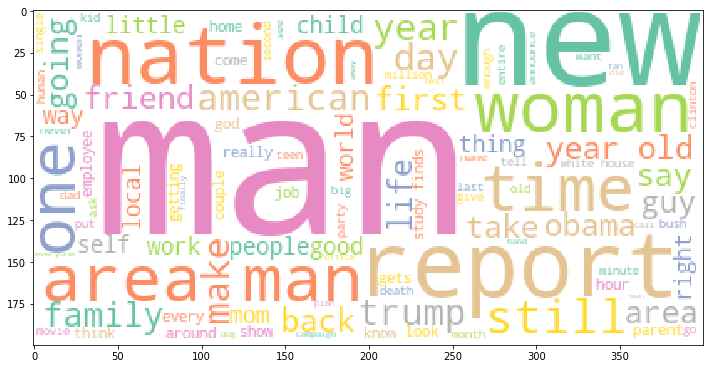

In [105]:
wc.generate(" ".join(sarcastic_words))
fig = plt.figure(1, figsize=(12, 12))
plt.imshow(wc)

#### Wordcloud of words occuring in normal headlines

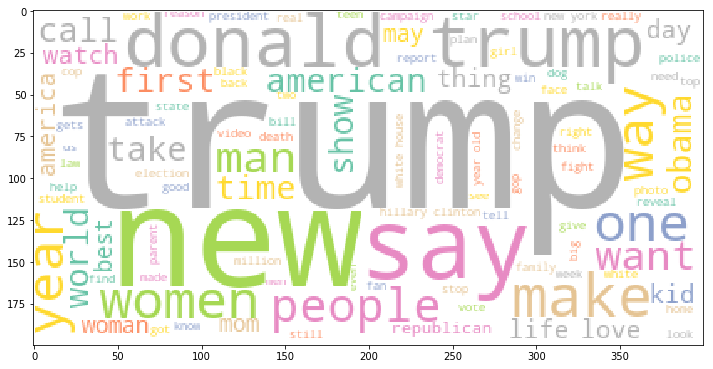

In [106]:
wc.generate(" ".join(normal_words))
fig = plt.figure(1, figsize=(12, 12))
plt.imshow(wc)

I did not gain much insights from the wordclouds even after removing stop words. I will have to do stemming or lemmatizing in the pre-processing section for the model to be more accurate. Also, will take two approaches, one using normal Bag og words and another using word embeddings.

## Preparing Data

I don't need article_link for the analysis, so I'll drop it.

In [107]:
headlines = headlines.drop(['article_link'], axis=1)
headlines.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [108]:
headlines.is_sarcastic = headlines.is_sarcastic.replace({0: 'normal', 1: 'sarcastic'})
headlines.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,normal
1,the 'roseanne' revival catches up to our thorn...,normal
2,mom starting to fear son's web series closest ...,sarcastic
3,"boehner just wants wife to listen, not come up...",sarcastic
4,j.k. rowling wishes snape happy birthday in th...,normal


In [109]:
headlines.isna().sum(axis=0)

headline        0
is_sarcastic    0
dtype: int64

We have no missing values in this dataset

In [110]:
print(f"Total headlines in the dataset: {headlines.shape[0]}")
print(f"Total duplicate headlines in the dataset: {headlines.shape[0] - headlines.headline.nunique()}")

Total headlines in the dataset: 26709
Total duplicate headlines in the dataset: 107


We have 107 duplicate headlines. Let's see which ones are duplicated

In [111]:
headlines[headlines.duplicated(['headline'])]

,headline,is_sarcastic
1091,antarctic observational comic running out of i...,sarcastic
2265,sunday roundup,normal
2975,the best chance to defeat roy moore may be for...,normal
3802,sunday roundup,normal
4605,sunday roundup,normal
5154,all y'all urged to go fuck yo' selves,sarcastic
5789,bird has big plans for cage,sarcastic
6383,sunday roundup,normal
6642,the funniest tweets from women this week,normal
6685,loser can't even get wife pregnant,sarcastic


In [112]:
headlines = headlines.drop_duplicates(['headline'])
print(f"Total headlines after removing duplicates: {headlines.shape[0]}")

Total headlines after removing duplicates: 26602


Let's split the data into training and testing datasets

In [113]:
X = headlines.headline.values
Y = headlines.is_sarcastic.values

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [115]:
print("Training data size: ", X_train.shape[0])
print("Testing data size: ", X_test.shape[0])

Training data size:  21281
Testing data size:  5321


In [116]:
def get_wordnet_pos(word):
    """
    Map POS tag to first character lemmatize() accepts
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}

    return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)

In [117]:
import string

def tokenize(text):
    """
    Split the input sentence into tokens. Following steps are taken here:
        remove punctuations -> lowercase -> remove stop words -> lemmatize
    """
    translator = str.maketrans('', '', string.punctuation)
    # normalize
    text = text.strip().lower().translate(translator)
    tokens = word_tokenize(text)
    stop_words = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens if token not in stop_words]
    return tokens

In [118]:
# Example comparison
lemmatizer = WordNetLemmatizer()
word_1 = ["I'm",'having', 'an', 'amazing', 'party']
word_2 = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_1]
print('Before lemmatization :\t',word_1)
print('After lemmatization :\t',word_2)

Before lemmatization :	 ["I'm", 'having', 'an', 'amazing', 'party']
After lemmatization :	 ["I'm", 'have', 'an', 'amaze', 'party']


## Analysis

### Building Machine Learning Pipeline

#### Using Random Forest

In [129]:
ml_pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier())
])

In [120]:
ml_pipeline.fit(X_train, y_train)

/opt/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [121]:
def evaluate(model, x):
    y_pred = model.predict(x)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):2f}\n\n")
    print(classification_report(y_test, y_pred))

In [122]:
evaluate(ml_pipeline, X_test)

Accuracy: 0.734073


              precision    recall  f1-score   support

      normal       0.72      0.87      0.79      3031
   sarcastic       0.77      0.55      0.64      2290

   micro avg       0.73      0.73      0.73      5321
   macro avg       0.74      0.71      0.71      5321
weighted avg       0.74      0.73      0.72      5321



The accuracy of 73% is decent but I want to acheive more. Next I'm going to try hyper-paramaeter tuning using Grid Search

#### Improving Model using Grid Search

In [130]:
parameters = {
    'clf__n_estimators': [200, 300, 500]
}

cv = GridSearchCV(ml_pipeline, param_grid=parameters, cv=3)
cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'clf__n_estimators': [200, 300, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [131]:
evaluate(cv, X_test)

Accuracy: 0.756813


              precision    recall  f1-score   support

      normal       0.74      0.87      0.80      3031
   sarcastic       0.78      0.60      0.68      2290

   micro avg       0.76      0.76      0.76      5321
   macro avg       0.76      0.74      0.74      5321
weighted avg       0.76      0.76      0.75      5321



I tried may different combinations, but all of them were taking too long to complete. So went with the above simple one which gave around 75% accuracy.

#### Using Bernoulli Naive Bayes

Since Naive Bayes is widely used in use cases where text is involved like spam detection, sentiment analysis and more, let's see how it performs in our case.

In [126]:
from sklearn.naive_bayes import BernoulliNB

ml_pipeline2 = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', BernoulliNB())
])

In [127]:
ml_pipeline2.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...se, use_idf=True)), ('clf', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))])

In [128]:
evaluate(ml_pipeline2, X_test)

Accuracy: 0.795903


              precision    recall  f1-score   support

      normal       0.78      0.88      0.83      3031
   sarcastic       0.82      0.68      0.74      2290

   micro avg       0.80      0.80      0.80      5321
   macro avg       0.80      0.78      0.79      5321
weighted avg       0.80      0.80      0.79      5321



Bernoulli Naive Bayes gives an accuracy of 79.5%, almost 3% more than optimized Random Forest Classifier.

#### Using Deep Learning (LSTM)

Before we build a deep neural network, let's first tokenize our data.

In [51]:
lemmatized_data = []
for hl in headlines.headline:
    lemmatized_data.append(tokenize(hl))

In [140]:
lemmatized_data[:10]

[['former',
  'versace',
  'store',
  'clerk',
  'sue',
  'secret',
  'black',
  'code',
  'minority',
  'shopper'],
 ['roseanne',
  'revival',
  'catch',
  'thorny',
  'political',
  'mood',
  'well',
  'bad'],
 ['mom',
  'start',
  'fear',
  'son',
  'web',
  'series',
  'closest',
  'thing',
  'grandchild'],
 ['boehner',
  'want',
  'wife',
  'listen',
  'come',
  'alternative',
  'debtreduction',
  'idea'],
 ['jk', 'rowling', 'wish', 'snape', 'happy', 'birthday', 'magical', 'way'],
 ['advance', 'world', 'woman'],
 ['fascinate', 'case', 'eat', 'labgrown', 'meat'],
 ['ceo', 'send', 'kid', 'school', 'work', 'company'],
 ['top', 'snake', 'handler', 'leaf', 'sinking', 'huckabee', 'campaign'],
 ['friday', 'morning', 'email', 'inside', 'trump', 'presser', 'age']]

In [141]:
sarcastic_words.extend(normal_words)
print(f"Total words in dataset: {len(set(sarcastic_words))}")

Total words in dataset: 36445


36445 words are too much for our deep learning model. Let's focus only on the top 20000 words from this dataset

In [142]:
vocab_size = 20000
max_len = len(sorted(lemmatized_data, key=lambda x: len(x))[-1])
print("Max length of headline: ", max_len)

Max length of headline:  27


In [143]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(lemmatized_data)

In [144]:
sequences = tokenizer.texts_to_sequences(lemmatized_data)
X = pad_sequences(sequences, maxlen=max_len)
Y = headlines['is_sarcastic'].replace({'normal': 0, 'sarcastic': 1}).values
Y = np.vstack(Y)

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
y_train.shape

(21281, 1)

#### Building the model

In [149]:
embedding_dims = 64

model = Sequential()
model.add(Embedding(vocab_size, embedding_dims, input_length = max_len))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, activation='relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='rmsprop',metrics = ['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 27, 64)            1280000   
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_7 (Activation)    (None, 1)                 0         
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________
None


In [150]:
from keras.callbacks import EarlyStopping
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

batch_size = 128
n_epochs = 10


In [151]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_split=0.05)

Train on 20216 samples, validate on 1065 samples
Epoch 1/10
20216/20216 [==============================] - 28s 1ms/step - loss: 0.5857 - acc: 0.6914 - val_loss: 0.4942 - val_acc: 0.7831
Epoch 2/10
20216/20216 [==============================] - 23s 1ms/step - loss: 0.3892 - acc: 0.8326 - val_loss: 0.4375 - val_acc: 0.8038
Epoch 3/10
20216/20216 [==============================] - 25s 1ms/step - loss: 0.3071 - acc: 0.8714 - val_loss: 0.4495 - val_acc: 0.8094
Epoch 4/10
20216/20216 [==============================] - 23s 1ms/step - loss: 0.2633 - acc: 0.8922 - val_loss: 0.4711 - val_acc: 0.8122
Epoch 5/10
20216/20216 [==============================] - 23s 1ms/step - loss: 0.2334 - acc: 0.9064 - val_loss: 0.4485 - val_acc: 0.7887
Epoch 6/10
20216/20216 [==============================] - 23s 1ms/step - loss: 0.2103 - acc: 0.9158 - val_loss: 0.4828 - val_acc: 0.7915
Epoch 7/10
20216/20216 [==============================] - 22s 1ms/step - loss: 0.1913 - acc: 0.9237 - val_loss: 0.5193 - val_acc:

In [152]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Accuracy of basic LSTM model: {acc}")

5321/5321 [==============================] - 3s 566us/step
Accuracy of basic LSTM model: 0.8052997557074252


With Deep Learning based approach, we are able to get 81% accuracy without any hyperparameter optimization. So with hyperparameter optimization and more complex models specifically used for NLP like 1-d CNN and BiLSTM, the results would surely be better. But, these approaches are outside the scope of this discussion

Let's compare how our three models, namely: 
- Random Forest
- BernoulliNB
- Basic LSTM

In [155]:
plot_bar(['Random Forest', 'BernoulliNB', 'Basic LSTM'], [0.756, 0.795, 0.81], title="Accuracy")

BerboulliNB and Basic LSTM have comparable accuracy. But since we'll be running the webapp on local machines with limited computing power, BernoulliNB will be much faster and less resource consuming than LSTM, so we will use Naive Bayes model for the webapp

### Saving the models

In [138]:
with open('models/rf.model', 'wb') as f:
    pickle.dump(cv, f)
    
with open('models/bernoulliNB.model', 'wb') as f:
    pickle.dump(ml_pipeline2, f)
    
with open('models/basicLSTM.model', 'wb') as f:
    pickle.dump(model, f)

## Conclusion

- I tried three different models but still not able to breach 90% mark. Deep Learning method seems promising, but we are short of data to use more advanced deep learning models. Even a basic LSTM seemed to be overfitting in just 10 epochs. So, one thing which would be good to have would be more data

- From amongst traditional machine learning methods, Naive Bayes works better than Random Forest in my case. Naive Bayes is a good algorithm for working with text classification. When dealing with text, it’s very common to treat each unique word as a feature, and since the typical person’s vocabulary is many thousands of words, this makes for a large number of features. The relative simplicity of the algorithm and the independent features assumption of Naive Bayes make it a strong performer for classifying texts.

- For the webapp, I'm going with Naive Bayes for the following reasons:
    - It requires less model training time
    - Naive Bayes model size is low and quite constant with respect to the data
    - Naive Bayes can quickly adapt to changes in data whereas we would have to rebuild Random Forest everytime

My final thoughts would be that Sarcasm detection is a very difficult challenge as even people don't seem to get it many times. It is a complicated structure of human communication. Rather than working only with words, according to me, data scientists should collaborate with language experts to indentify more features which would make learning easier for the models and help data scientists gain more domain knowledge to create better models